
# Processus Gaussiens - Implémentation Manuelle

Ce notebook implémente un processus gaussien de manière **manuelle**, avec une fonction de noyau RBF paramétrable.
Il permet :
- de modifier les paramètres du noyau (longueur de corrélation, variance),
- d'observer leur impact sur la prédiction,
- de projeter les sorties sur un domaine contraint.

---


In [6]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider


In [7]:
def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)


In [11]:

def gp_predict_manual(X_train, y_train, X_test, kernel, kernel_params, sigma_y=1e-8):
    K =kernel(X_train, X_train, **kernel_params) + sigma_y**2 * np.eye(len(X_train))
    K += 1e-8 * np.eye(len(K))  # Ajout de jitter pour la stabilité numérique

    K_s = kernel(X_train, X_test, **kernel_params)
    K_ss = kernel(X_test, X_test, **kernel_params)

    K_inv = np.linalg.inv(K)

    mu_s = K_s.T @ K_inv @ y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    # Ensure covariance diagonal is non-negative before taking the square root
    std_s = np.sqrt(np.maximum(np.diag(cov_s), 0))
    return mu_s, std_s


In [12]:

# Données d'entraînement
n = 30
X_train = np.sort(6 * np.random.rand(n, 1) - 3, axis=0)
y_train = np.sin(X_train).ravel() + 0.2 * np.random.randn(n)

# Points de test
X_test = np.linspace(-5, 5, 200).reshape(-1, 1)


@interact(length_scale=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Length Scale'),
          sigma_f=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Sigma_f'))
def update_gp(length_scale=1.0, sigma_f=1.0):
    params = {"length_scale": length_scale, "sigma_f": sigma_f} # Paramètres du noyau RBF
    mu, std = gp_predict_manual(X_train, y_train, X_test, rbf_kernel, params)

    # Vraie fonction
    f_true = np.sin(X_test).ravel()

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f_true, 'b--', label='Vraie fonction $f(x) = \sin(x)$')
    plt.plot(X_test, mu, 'r-', label='Prédiction moyenne GP')
    plt.fill_between(X_test.ravel(), mu - 2*std, mu + 2*std, color='orange', alpha=0.3, label='Incertitude ±2σ')
    plt.plot(X_train, y_train, 'ko', label='Données d\'entraînement')

    plt.title("Régression avec Processus Gaussien")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.ylim(-2, 2)
    plt.show()



<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hilal\AppData\Local\Temp\ipykernel_28796\1889614015.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(X_test, f_true, 'b--', label='Vraie fonction $f(x) = \sin(x)$')


interactive(children=(FloatSlider(value=1.0, description='Length Scale', max=5.0, min=0.1), FloatSlider(value=…

Remarquons que Quand length_scale → 0, le noyau RBF devient presque nul sauf quand 𝑥=𝑥′, donc la matrice de covariance 𝐾 devient presque diagonale → mal conditionnée → instabilité à l’inversion.
Dans ce cas, la moyenne prédite saute partout et l’incertitude explose.

Voyons maintenant ce qu'il se passe si le domaine d'entrée est contraint

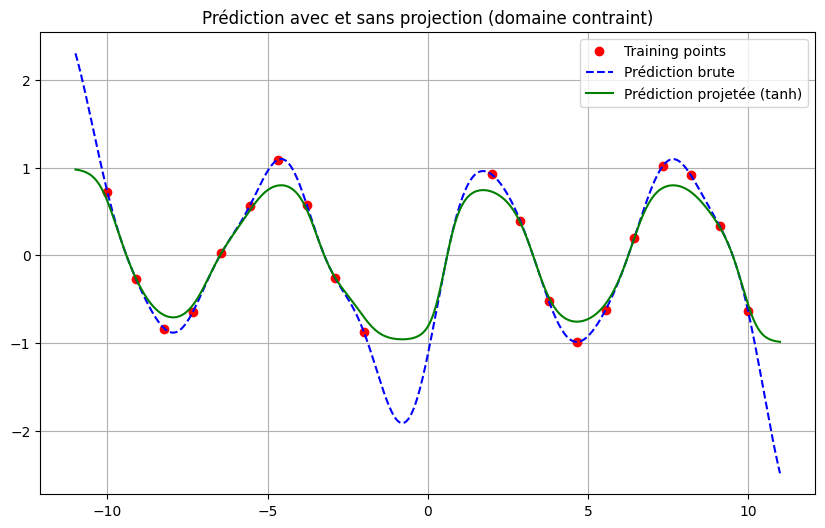

In [14]:
# Domaine contraint
domain_min, domain_max = -1, 1

# Paramètres
kernel_params = {"length_scale": 1.5, "sigma_f": 1.0}
mu, _ = gp_predict_manual(X_train, y_train, X_test, rbf_kernel, kernel_params)

# Projection douce avec tanh
mu_projected = np.tanh(mu)

plt.figure(figsize=(10,6))
plt.plot(X_train, y_train, 'ro', label='Training points')
plt.plot(X_test, mu, 'b--', label='Prédiction brute')
plt.plot(X_test, mu_projected, 'g-', label='Prédiction projetée (tanh)')
plt.title("Prédiction avec et sans projection (domaine contraint)")
plt.legend()
plt.grid(True)
plt.show()


Ce n’est pas une vraie modélisation contrainte (comme un GP sur espace fonctionnel restreint), mais cela permet toutefois d'aboutir à certaines obdeervations: 
-1. Une GP classique ne respecte pas forcément les contraintes naturelles
Même si la fonction vraie est bornée (ex: proba, signal physique), la GP, sans contrainte explicite, peut extrapoler hors domaine.
-2. Une projection douce (tanh) permet d'encadrer les prédictions tout en conservant la continuité
La tanh agit comme une fonction de liaison continue entre les valeurs extrêmes, préservant la forme de la fonction sans l’écraser comme le ferait un clip() dur.
-3. Cette méthode est utile si la sortie doit rester bornée


Ici je retente le plot de la prédiction précedente sans interface interactive

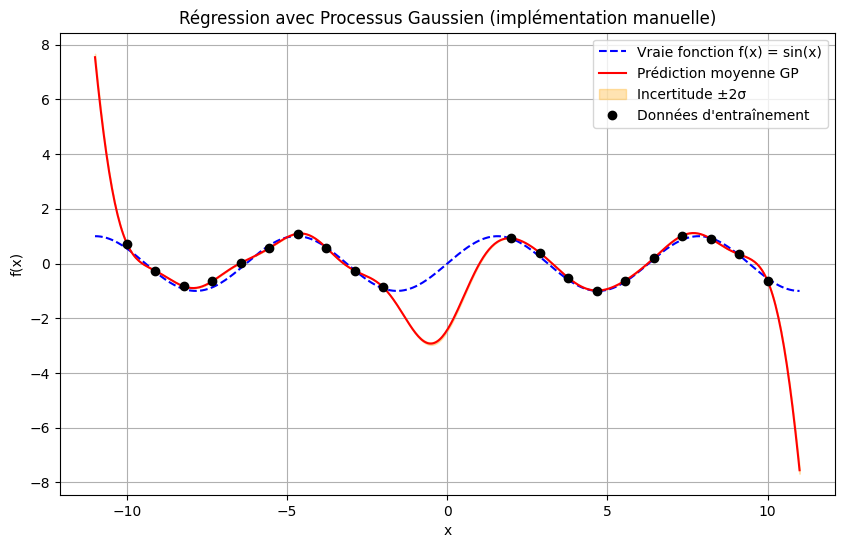

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction cible
def f(x):
    return np.sin(x)

# Kernel RBF manuel
def rbf_kernel(X1, X2, length_scale=2.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1,1) + np.sum(X2**2, axis=1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Données d'entraînement
rng = np.random.RandomState(0)
X_left = np.linspace(-10, -2, 10).reshape(-1, 1)
X_right = np.linspace(2, 10, 10).reshape(-1, 1)
X_train = np.vstack((X_left, X_right))
y_train = f(X_train).ravel() + rng.normal(0, 0.1, X_train.shape[0])

# Données de test
X_test = np.linspace(-11, 11, 500).reshape(-1, 1)

# Matrices de covariance
K = rbf_kernel(X_train, X_train) + 1e-8 * np.eye(len(X_train))  # Jitter
K_s = rbf_kernel(X_train, X_test)
K_ss = rbf_kernel(X_test, X_test)

# Inversion
K_inv = np.linalg.inv(K)

# Prédiction
mu_s = K_s.T @ K_inv @ y_train
cov_s = K_ss - K_s.T @ K_inv @ K_s
std_s = np.sqrt(np.diag(cov_s))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), 'b--', label="Vraie fonction f(x) = sin(x)")
plt.plot(X_test, mu_s, 'r-', label="Prédiction moyenne GP")
plt.fill_between(X_test.ravel(), mu_s - 2*std_s, mu_s + 2*std_s, color='orange', alpha=0.3, label="Incertitude ±2σ")
plt.plot(X_train, y_train, 'ko', label="Données d'entraînement")
plt.title("Régression avec Processus Gaussien (implémentation manuelle)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()


Essayons maintenant de passer en deux dimensions